In [1]:
import pytest
import torch

In [2]:
import sys
sys.path.insert(0, '../tests/')

In [3]:
from conftest import *
from pathlib import Path

paths = dict(data = Path('../data/'))

device = 'cuda:0'

use_cuda = True

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
%matplotlib inline

# Set up models

# Evaluate

### Evaluate on saved test image

In [33]:
test_star = torch.load(paths["data"].joinpath("3_star_test.pt"))
test_image = test_star["images"].to(device)

In [34]:
test_image.shape

torch.Size([1, 1, 30, 30])

In [35]:
with torch.no_grad():
    # get the estimated params
    trained_encoder.eval()
    (
        n_sources_per_tile,
        locs_per_tile,
        galaxy_params_per_tile,
        log_fluxes_per_tile,
        galaxy_bool_per_tile,
    ) = trained_encoder.map_estimate(test_image)
    
    (
        n_sources,
        locs,
        galaxy_params,
        log_fluxes,
        galaxy_bool,
    ) = trained_encoder.get_full_params_from_sampled_params(n_sources_per_tile,
                                                            locs_per_tile,
                                                            galaxy_params_per_tile,
                                                            log_fluxes_per_tile,
                                                            galaxy_bool_per_tile)

In [42]:
torch.save(trained_encoder.state_dict(), 'star_encoder')

In [43]:
trained_encoder.load_state_dict(torch.load('star_encoder'))

<All keys matched successfully>

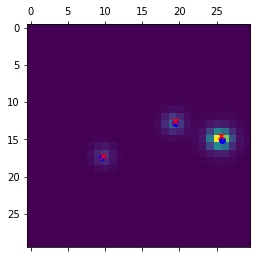

In [36]:
plt.matshow(test_image[0, 0].cpu())
plt.scatter(test_star['locs'][0, :, 1] * slen - 0.5, 
            test_star['locs'][0, :, 0] * slen - 0.5, color = 'blue')

plt.scatter(locs.cpu()[0, :, 1] * slen - 0.5, 
            locs.cpu()[0, :, 0] * slen - 0.5, color = 'red', marker = 'x')


In [37]:
# test n_sources and locs
assert n_sources == test_star["n_sources"].to(device)

In [38]:
n_sources

tensor([3.], device='cuda:0')

In [39]:
diff_locs = test_star["locs"].sort(1)[0].to(device) - locs.sort(1)[0]
diff_locs *= test_image.size(-1)
print(diff_locs)
assert diff_locs.abs().max() <= 0.5



tensor([[[ 0.2251, -0.1218],
         [ 0.4283,  0.0158],
         [ 0.1610,  0.1760]]], device='cuda:0')


In [40]:
# test fluxes
diff = test_star["log_fluxes"].sort(1)[0].to(device) - log_fluxes.sort(1)[0]
assert torch.all(diff.abs() <= log_fluxes.sort(1)[0].abs() * 0.10)
assert torch.all(
    diff.abs() <= test_star["log_fluxes"].sort(1)[0].abs().to(device) * 0.10
)

In [ ]:
# class TestStarWakeNet:
#     @pytest.fixture(scope="class")
#     def init_psf_setup(self, decoder_setup, device_setup):
#         # initialize psf params, just add 1 to each sigmas
#         fitted_psf_params = decoder_setup.get_fitted_psf_params()
#         init_psf_params = fitted_psf_params.clone()[None, 0]
#         init_psf_params[0, 1:3] += torch.tensor([1.0, 1.0]).to(device_setup.device)
#         init_psf = PowerLawPSF(init_psf_params).forward().detach()
#         return {"init_psf_params": init_psf_params, "init_psf": init_psf}

#     def test_star_wake(
#         self, trained_encoder, star_dataset, init_psf_setup, paths, device_setup
#     ):
#         # load the test image
#         # 3-stars 30*30 pixels.
#         test_star = torch.load(paths["data"].joinpath("3_star_test.pt"))
#         test_image = test_star["images"]
#         test_slen = test_image.size(-1)

#         # TODO: Reuse these when creating the background in the fixture
#         # initialize background params, which will create the true background
#         init_background_params = torch.zeros(1, 3, device=device_setup.device)
#         init_background_params[0, 0] = 686.0

#         n_samples = 1
#         hparams = {"n_samples": n_samples, "lr": 0.001}
#         image_decoder = star_dataset.image_decoder
#         assert image_decoder.slen == test_slen
#         wake_phase_model = wake.WakeNet(
#             trained_encoder,
#             image_decoder,
#             test_image,
#             init_background_params,
#             hparams,
#         )

#         # run the wake-phase training
#         n_epochs = 1

#         wake_trainer = pl.Trainer(
#             gpus=device_setup.gpus,
#             profiler=None,
#             logger=False,
#             checkpoint_callback=False,
#             min_epochs=n_epochs,
#             max_epochs=n_epochs,
#             reload_dataloaders_every_epoch=True,
#         )

#         wake_trainer.fit(wake_phase_model)
